# Machine Learning Engineer Nanodegree
## Project: Predicting article's retweets and favorites based on its title using Machine Learning

In this notebook is presented the code used to evaluate and test the assumptions of the prediction algorithm. The final report can be fully read on the attached file [final-report.pdf](https://github.com/flaviohenriquecbc/machine-learning-capstone-project/blob/master/final-report.pdf)

Choosing a good title for an article is an important step of the writing process. The more interesting the article title seems, the higher the chance a reader will interact with the whole content. This project focus on predicting the number of shares and favorites on Twitter from FreeCodeCamp's articles based on its titles. This problem is a classification task using  Supervised Learning. With data from FreeCodeCamp on Twitter and Medium, it was used machine learning methods including Support Vector Machines (SVM), Decision Trees, Gaussian Naive Bayes (GaussianNB), K-Nearest Neighbors and Logistic Regression to make the predictions.

## Exploring the Data
Load the FreeCodeCamp Twitter statistics and Medium statistics.

In [168]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')

sns.set_style('whitegrid')
sns.set_palette('coolwarm')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/flavio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [117]:
# Read imported data
title_stat = pd.read_json("dataset/dataset-tweets-final.json")
print("Title statistic data read successfully!")

Title statistic data read successfully!


### Data Exploration
Let's check how the dataset seems like. Some columns were ommited from this table (id, created_at and url)

The data used to predict how titles will perform was gathered from the accounts of the non-profit organization FreeCodeCamp on Medium and Twitter. On both social platforms, it was possible to get public information about how the users interacted with the content, using as “Favorites” and “Retweets” from Twitter, and “Claps” from Medium.

Correlating the number of “Favorites” and “Retweets” from Twitter with a Medium article, is an attempt to isolate the effect of number of reached readers and number of Medium “Claps”. Because the more the article is shared in different platforms, the more readers it will reach and the more Medium “Claps” it will receive. Using only the Twitter statistic, it is expected that the articles reached initially almost the same number of readers (that are the followers of the FreeCodeCamp account on Twitter), and their performance and interactions are limited to the characteristics of the tweet, for example, the title of the article, that is exactly what we want to measure.


In [118]:
# Remove some columns to print
title_stat = title_stat.drop(['id', 'created_at', 'url'], axis=1)
# calculate length of the titles
title_stat['text_lenght'] = title_stat['text'].str.len()
# reorder the columns
title_stat = title_stat[title_stat.columns[[4, 0, 3, 2, 5, 1]]]
# rename the columns
temp = title_stat.rename(index=str, columns={"favorite_count": "Favorites (Twitter)", "medium_categories": "Categories (Medium)", "medium_claps": "Claps (Medium)", "retweet_count": "Retweet (Twitter)", "text": "Title (Twitter)", "text_lenght": "Title Length"})
title_stat = title_stat.rename(index=str, columns={"favorite_count": "Favorites", "medium_categories": "Categories", "medium_claps": "Claps", "retweet_count": "Retweet", "text": "Title", "text_lenght": "Title Length"})
# limit the total number of lines to print
temp.head()

,Title (Twitter),Favorites (Twitter),Retweet (Twitter),Claps (Medium),Title Length,Categories (Medium)
0,How to use JSON padding (and other options) to...,10,5,177,76,"[JavaScript, HTML, Web Development, Tutorial, ..."
1,How to build GitHub search functionality in Re...,19,7,61,90,"[React, Tech, Functional Programming, Programm..."
2,How to read and write Mindful Minutes from iOS...,11,6,54,93,"[iOS, Software Development, Programming, Web D..."
3,"How to make more money on Upwork, by @jpmorris",39,9,139,46,"[Freelancing, Tech, Web Development, Web Desig..."
4,"b""Let's build a fun little game: Learn advance...",62,14,342,118,"[CSS, Games, Tech, Programming, React]"


### Exploratory Visualization

This section will explore the data visualization of the existing dataset and analyze the possible metrics that will be used to understand the solution. We will try to identify the relationship between each one of the features with the overall performance of the article. Within the following steps we will discuss:

* General statistic overview of the dataset
* Distribution of retweets, claps and favorites
* Relation of the title length with the performance of the article
* Relation of the article's categories with the performance of the article
* Relation of the article's words with the performance of the article
* Try to identify the relation between the features


#### Overall Statistics

We will analyze here the high level statistics of the articles. Try to understand how many times the articles were in average re-tweeted, clapped or marked as favorites. Also understand the average title length of the articles.

In [119]:
# calculate length of the titles
title_stat['Title Length'] = title_stat['Title'].str.len()
title_stat.describe()

,Favorites,Retweet,Claps,Title Length
count,717.000000,717.000000,717.000000,717.000000
mean,49.496513,16.507671,284.184100,80.557880
std,45.342200,15.696013,273.274566,22.121265
min,0.000000,0.000000,1.000000,21.000000
25%,20.000000,7.000000,6.000000,65.000000
50%,34.000000,11.000000,238.000000,79.000000
75%,64.000000,20.000000,469.000000,97.000000
max,298.000000,125.000000,997.000000,146.000000


From this statistic is possible to understand the order of magnitude of our dataset. Articles normally are re-tweeted and marked as favorite around tens of times and clapped hundreds of times. It is possible to check the maximum values from all the three variables, re-tweet and favorite hundreds and clap thousand of times. From these numbers we can define what is expected from our articles and the interaction with them. The length of the text goes from 21 to 146 characters, as expected, for a tweet content.

#### Histogram and Box plots

In this section we will check how the multiple features are distributed.

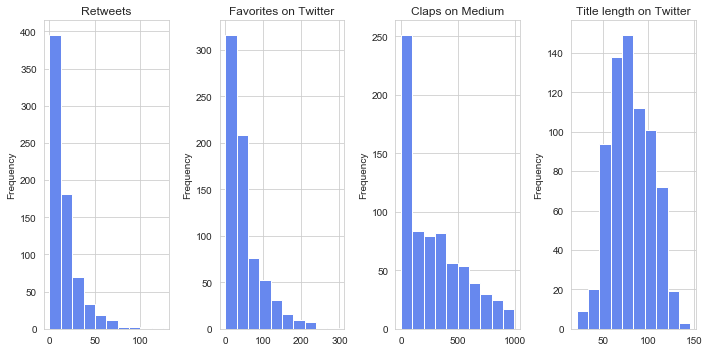

In [120]:
title_length = 'Title Length'
# set the columns that will show statistic and graph
columns = [{'column_name': 'Retweet', 'column_text': 'Retweets'},
           {'column_name': 'Favorites', 'column_text': 'Favorites on Twitter'},
           {'column_name': 'Claps', 'column_text': 'Claps on Medium'},
           {'column_name': title_length, 'column_text': 'Title length on Twitter'}] 

# plot histogram of columns
plt.figure(figsize=(10, 5))
for el in columns:
    column = title_stat[el['column_name']]
    plt.subplot(1, 4, columns.index(el) + 1)
    plt.tight_layout()
    column.plot.hist(orientation='vertical', cumulative=False, title=el['column_text'])

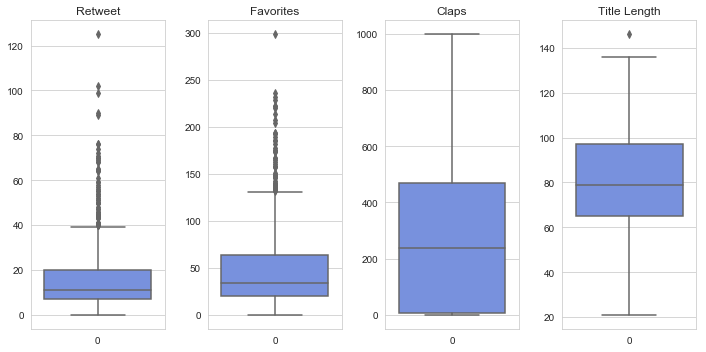

In [121]:
# plot boxplots
plt.figure(figsize=(10, 5))      
for el in columns:
    column = title_stat[el['column_name']]
    plt.subplot(1, 4, columns.index(el) + 1)
    plt.tight_layout()
    plt.title(el['column_name']);
    sns.boxplot(data=column);

From these histograms together with the overall statistic and the box plots, we can notice that we have a Gaussian distribution for the text length and the average length is around 80 characters. Favorite, re-tweet and claps are positive-skewed, i.e. they are concentrated on the left part of the graph, meaning that a small part of the articles will over-perform about readers' interaction and biggest part of them will generate less interaction.


#### Scatter Matrix

Here we try to find a relationship between the multiple features that we gathered from Twitter and Medium.


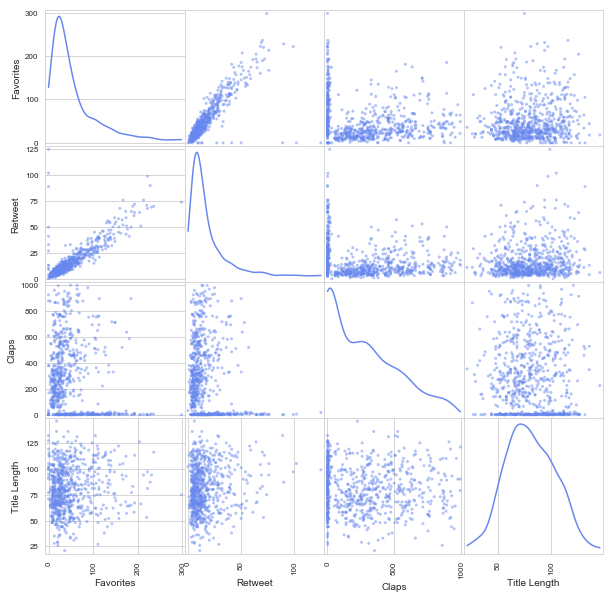

In [122]:
temp = pd.plotting.scatter_matrix(title_stat, diagonal="kde", figsize=(10, 10))

#### Title length that performed better

Here we analyze the relationship between the length of the title with its performance. For this experiment, we just considered the 25\% top performers of each feature.

In [123]:
# remove the outlier data ponts. We use the forumla:
# Outlier < Q_1 - 1.5* IQR
# Outlier > Q_3 + 1.5 * IQR
# Where Q_1 and Q_3 are the first and third quartile
# and IQR is the Interquartile Range (IQR = Q_3 - Q_1).
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    non_outliers = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)
    return df.loc[non_outliers]

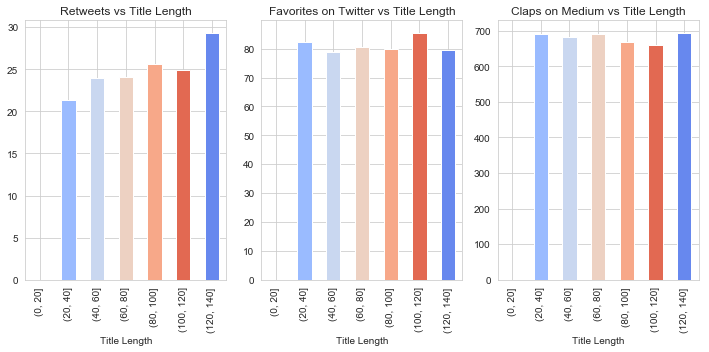

In [124]:
PERCENTAGE = 25
# plot relation between the number of retweet/favorite/claps and the text length
plt.figure(figsize=(10, 5))      
for el in columns:
    column = title_stat[el['column_name']]
    if el['column_name'] != title_length:
        plt.subplot(1, 3, columns.index(el) + 1)
        plt.tight_layout()
        # remove outliers
        title_stat_top = remove_outliers(title_stat, el['column_name'])
        # get top PERCENTAGE%
        title_stat_top = title_stat_top.sort_values(by=[el['column_name']], ascending=False).head(int(len(title_stat)*(PERCENTAGE/100.00)))
        temp = title_stat_top.groupby(pd.cut(title_stat_top[title_length], bins=np.arange(0, 140+20, step=20))).mean()[el['column_name']]
        temp.plot.bar()
        plt.title('{} vs Title Length'.format(el['column_text']));

To avoid being biased by outliers, we removed for each feature (favorites, re-tweets and claps) analysis the data points that don't fit the following formulas:

Outlier < Q_1 - 1.5* IQR

Outlier > Q_3 + 1.5 * IQR

Where Q_1 and Q_3 are the first and third quartile and IQR is the Interquartile Range (IQR = Q_3 - Q_1). 

We can notice from these graphics that longer titles tend to perform better than shorter ones for re-tweets, but for claps on Medium and favorites it seems to influence little.


#### Number of words in the title that performed better

After analyzing the title length and didn't reach any conclusion, we decided to investigate the number of words in the title.

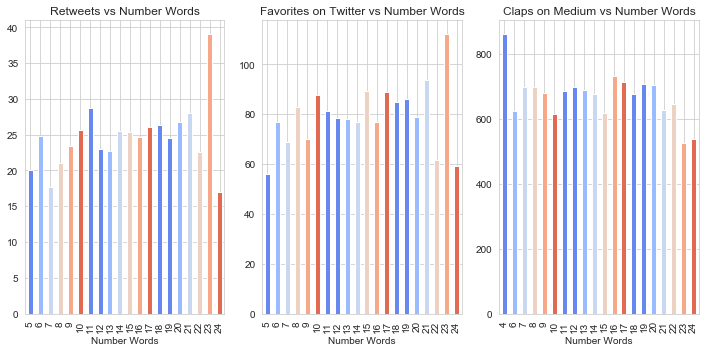

In [170]:
PERCENTAGE = 25

number_words = 'Number Words'
title_stat[number_words] = title_stat['Title'].str.split().apply(len)
# plot relation between the number of retweet/favorite/claps and the text length
plt.figure(figsize=(10, 5))      
for el in columns:
    column = title_stat[el['column_name']]
    if el['column_name'] != title_length:
        plt.subplot(1, 3, columns.index(el) + 1)
        plt.tight_layout()
        # remove outliers
        title_stat_top = remove_outliers(title_stat, el['column_name'])
        # get top PERCENTAGE%
        title_stat_top = title_stat_top.sort_values(by=[el['column_name']], ascending=False).head(int(len(title_stat)*(PERCENTAGE/100.00)))
        temp = title_stat_top.groupby(title_stat_top[number_words]).mean()[el['column_name']]
        temp.plot.bar()
        plt.title('{} vs {}'.format(el['column_text'], number_words));

From this second experience showed on this image, we reached the conclusion that neither number of words on the title affect considerably its performance.

#### Categories that performed better

Here we filtered the dataset and just analyzed the top 25\% performers for each one of the features. We wanted to have a clear overview how the categories perform compared between them. The outliers were also removed here.

In [125]:
# function to plot the top performers
PERCENTAGE = 25

# plot relation between the words used on medium title and the number of retweet/favorite/claps. Just for the top PERCENTAGE% performers
def plot_top_performers(lst_col):
    for el in columns:
        column = title_stat[el['column_name']]
        if el['column_name'] != title_length:
            plt.figure(figsize=(10, 5))
            # remove outliers
            title_stat_top = remove_outliers(title_stat, el['column_name'])
            title_stat_top = title_stat_top.sort_values(by=[el['column_name']], ascending=False).head(int(len(title_stat_top)*(PERCENTAGE/100.00)))
            x = pd.DataFrame({
                    col:np.repeat(title_stat_top[col].values, title_stat_top[lst_col].str.len())
                    for col in title_stat_top.columns.difference([lst_col])
                }).assign(**{lst_col:np.concatenate(title_stat_top[lst_col].values)})[title_stat_top.columns.tolist()]
            temp = x.groupby(lst_col).count()[el['column_name']].sort_values(ascending=False).head(20).sort_values(ascending=True)
            temp.plot.barh()
            plt.title('Most used {} on top {}% {}'.format(lst_col, PERCENTAGE, el['column_text']));

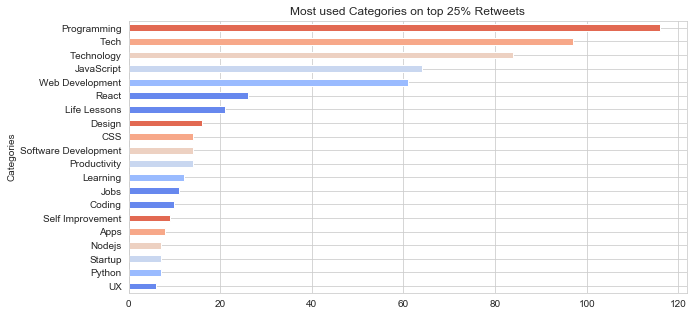

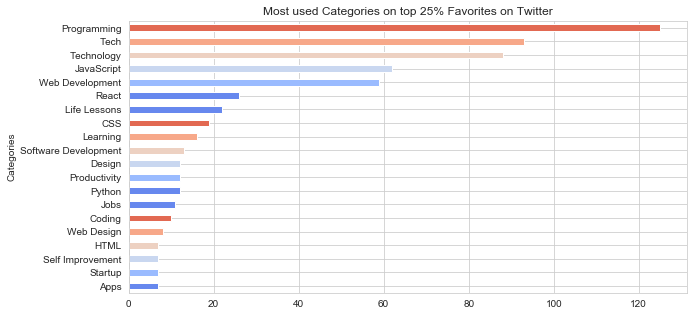

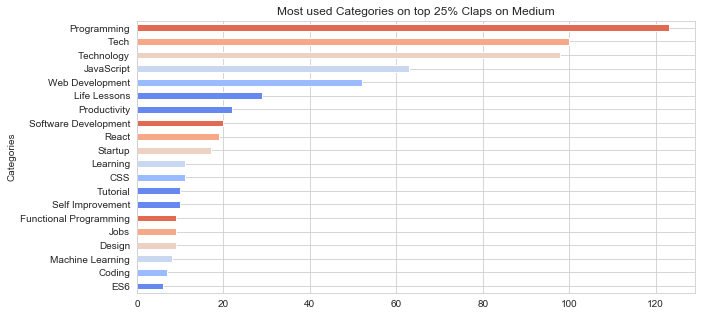

In [126]:
# plot relation between the tag used on medium (tag) and the number of retweet/favorite/claps
plot_top_performers('Categories')

From this statistic we notice that articles created with the following categories can increase the number of re-tweets, favorites and claps: "Programming", "Tech", "Technology", "JavaScript" and "Web Development".



#### Words that performed better

We repeated the same strategy of limiting the 25\% performers for the words on the title of the article. We wanted to understand if there are words that can boost the interaction from the readers. The outliers were also removed here.

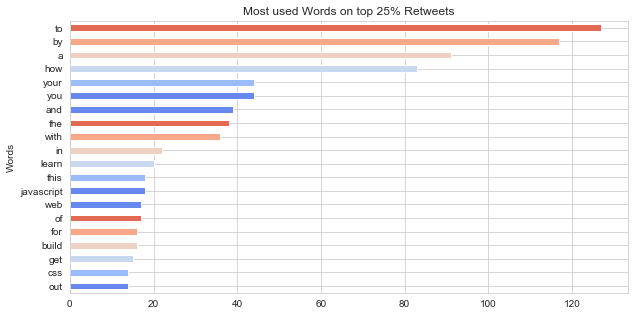

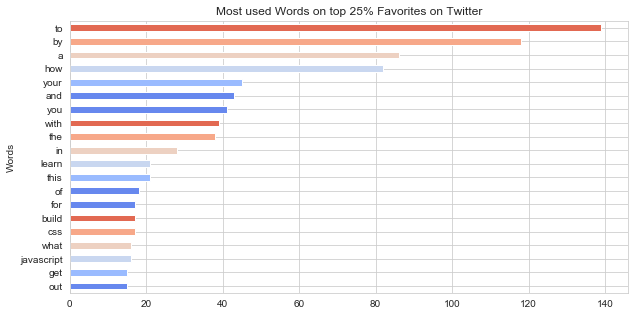

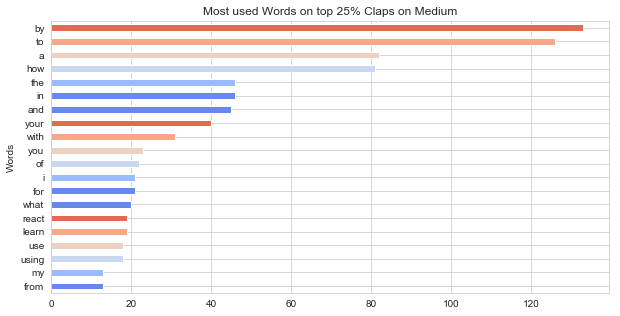

In [151]:
# create a column containing the words of the title
# remove special characters
temp = title_stat['Title'].str.lower().str.translate(str.maketrans('','','()!@#$:"?,./+')).str.split()
# temp = title_stat['Title'].str.lower().str.split()
# remove common words (it, a, the, ...)
stop=set(stopwords.words('english'))
title_stat['Words'] = temp.apply(lambda x: [item for item in x if item not in stop and not '\\' in item])
# title_stat['Words'] = temp
# print(stop) #uncomment to see removed words
# plot relation between the words used on medium title and the number of retweet/favorite/claps. Just for the top PERCENTAGE% performers
plot_top_performers('Words')

In this lexical analysis, we can notice that some words get much more attention on the FreeCodeCamp community than others, we noticed if we want to make our articles reach further in numbers talking about XXX, XXX, XXXX will increase this change.

## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [27]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print("Feature columns:\n{}".format(feature_cols))
print("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print("\nFeature values:")
print(X_all.head())

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [28]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [29]:
# Import any additional functionality you may need here
from sklearn.model_selection import train_test_split

# Set the number of training points
num_train = 95

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_train/(num_test + num_train), shuffle=True)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

**Gaussian Naive Bayes (GaussianNB):**
- Examples:
    - Identify spam: "An evaluation of Naive Bayesian anti-spam filtering" - https://arxiv.org/abs/cs/0006013
    - Also Text analysis and for banks in Credit Scoring.
- Strengths:
    - It is easy and fast to predict a class of test data set.
    - Naive Bayes perform better compare to other models assuming independence
    - It perform well in case of categorical input variable compared to numerical variables.
    - Computationally fast
    - Simple to implement
- Weakness:
    - Relies on independence assumption and will perform badly if this assumption is not met
- Good fit
    - I have chosen GaussianNB, because this family of algorithms can predict well with small set of data and when there is a large number of features comparatively. In our case, we have 395 students (training/testing data) and 30 features, and due to the fact that we can assume the features are independent between them.


**Decision Trees:**
- Examples:
    - Medical classifications: "Decision Trees: An Overview and Their Use in Medicine" - https://link.springer.com/article/10.1023/A:1016409317640
    - Insurance company can predict if their customers will pay the renew the premium account
    - Define a price of a house based on the number of rooms
- Strengths:
    - Simple to understand, interpret and visualize
    - Variable screening or Feature selection
    - Little effort for data preparation
- Weakness:
    - It is easy to overfit the data
    - It can be unstable because small variation in the data
- Good fit?
    - This model was chosen, because it can be easily interpreted, visualized and explained. Also due the fact that this model implicitly perform variable screening or feature selection.

**Support Vector Machine:**
- Examples: We can use SVM in:
    - Medical classification: "Gene Selection for Cancer Classification using Support Vector Machines" - https://link.springer.com/article/10.1023/A:1012487302797
    - Medical imaging
    - Image interpolation
    - Medical classification tasks
    - Predictions and financis analysis in Financial areas
    - Progression models to study the air quality in urban areas
- Strengths:
    - Effective in high dimensional spaces
    - Different kernel functions for various decision functions
- Weakness:
    - Poor performance when then number of features is bigger than the number of samples
    - Does no provide probability estimates.
- Good fit?
    - This model was chosen, because it works well then big quantity of features and relatively small quantity of data and to deal well with linear and non-linear datasets. And due the fact we have more samples than number of features, it can give us a good prediction.



### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [23]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print("F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print("F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test)))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state=0)
clf_C = SVC()

# Execute the 'train_predict' function for each classifier and each training set size
for clf in [clf_A, clf_B, clf_C]:
    print("==== Classifier: {} ====".format(clf.__class__.__name__))
    for n in [100, 200, 300]:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)
        print("\n")
    print("\n\n")

==== Classifier: GaussianNB ====
Training a GaussianNB using a training set size of 100. . .
Trained model in 0.0019 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.8235.
Made predictions in 0.0008 seconds.
F1 score for test set: 0.6555.


Training a GaussianNB using a training set size of 200. . .
Trained model in 0.0019 seconds
Made predictions in 0.0007 seconds.
F1 score for training set: 0.7986.
Made predictions in 0.0006 seconds.
F1 score for test set: 0.6935.


Training a GaussianNB using a training set size of 300. . .
Trained model in 0.0023 seconds
Made predictions in 0.0007 seconds.
F1 score for training set: 0.8028.
Made predictions in 0.0006 seconds.
F1 score for test set: 0.7360.





==== Classifier: DecisionTreeClassifier ====
Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0023 seconds
Made predictions in 0.0008 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0003 seconds.
F1 score for

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - GaussianNB**  

| Training Set Size | Training Time (s) | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0019           |         0.0010         |      0.8235      |      0.6555     |
| 200               |        0.0019           |         0.0007         |      0.7986      |      0.6935     |
| 300               |        0.0023           |         0.0007         |      0.8028      |      0.7360     |

** Classifer 2 - DecisionTreeClassifier**  

| Training Set Size | Training Time (s) | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.0023          |         0.0008         |      1.0000      |      0.5370     |
| 200               |         0.0020          |         0.0004         |      1.0000      |      0.7520     |
| 300               |         0.0036          |         0.0006         |      1.0000      |      0.7059     |

** Classifer 3 - SVC**  

| Training Set Size | Training Time (s) | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.0014          |         0.0022         |       0.8571     |     0.8000      |
| 200               |         0.0060          |         0.0021         |       0.8528     |     0.7600      |
| 300               |         0.0060          |         0.0044         |       0.8477     |     0.7917      |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **

After running an exhaustive number of tests and models variations, we reached the conclusion that we should adopt SVM (Support Vector Machine) to predict if the student might need an early Intervention. From the comparison shown on the table above, we can notice that the SVM has a F1 score (which measures accuracy of the predictions) better then the others (GaussianNB and SVC) for its predictions.

We also noticed that the time to train and test the data vary between then, but for our specific case, they can be ignored as they are very little and also because we prefer a bigger accurancy than a smaller time.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

Support Vector Machine is a model that finds the best way to draw a surface (linear or not) to divide the data into two groups. In our case, it divides the ones that need intervention from the ones that don't. This model take in consideration each feature (gender, age, famsize, ...) of our dataset and try to correlate them and find a surface that distinguises the two groups. After using the data of the previous students to tune the model, we use the data of the new students to predict if they need or not intervention.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [32]:
from sklearn.grid_search import GridSearchCV 
from sklearn.metrics import make_scorer
from sklearn.svm import SVC

parameters = {
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':[1, 2, 3, 4, 5, 6, 7],
    'C':[0.5, 1, 2],
}

# Initialize the classifier
clf = SVC()

# Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label="yes")

# Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, param_grid = parameters,scoring=f1_scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print("Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train)))
print("Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test)))

Made predictions in 0.0026 seconds.
Tuned model has a training F1 score of 0.8295.
Made predictions in 0.0010 seconds.
Tuned model has a testing F1 score of 0.8133.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **

The final training and testing F1 score are: 0.8295 and 0.8133.
We can notice the training F1 score **decreased** from 0.8477 to 0.8295 in comparison with the untuned model. 
And that the testing F1 score **increased** from 0.7917 to 0.8133.
We can understand that with the new parameters, the model is generalizing better the prediction decision tree.




> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.